Ahora vamos a mejor nuestro codigo para tener lecturas entre caad incremento del tiempo y para que sea una funcion que podamos invocar cuando queramos

In [1]:
!adb devices && adb forward tcp:9999 tcp:2222

List of devices attached
R88DEAEY55Y59THU	device



In [2]:
import android
droid = android.Android()
droid.ttsSpeak("Listo para recibir instrucciones")

Result(id=0, result=None, error=None)

In [3]:
import pandas as pd
import time
%matplotlib inline

def capturaDatosAceleracion():
    """
            Una funcion simple que registra lecturas del acelerometro y las
            publica en Databin 
            Incluye interaccion con usuario
    """
    aceleracion = []
    tiempoCensado = 0.
    tiempoTotal = 3000

    droid.startSensingTimed(2,100)
    
    while tiempoCensado <= tiempoTotal:
        aceleracion.append(droid.sensorsReadAccelerometer().result)
        time.sleep(100/1000.00)
        tiempoCensado += 100
    droid.stopSensing();
    
    return pd.DataFrame(aceleracion, columns=["Ax","Ay","Az"])

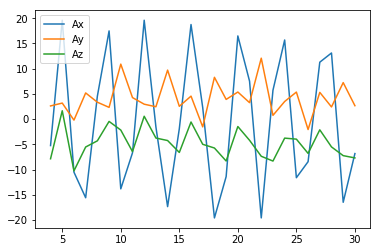

In [4]:
acel = capturaDatosAceleracion()
acel.plot()

Haremos un ejercicio similar con sensores de localizacion (de hecho [ya lo hemos usado, en nuestra primera leccion](../Semana1/L02_Mi-primer-app-de-python-en-Android.ipynb)). Sin embargo esta vez veremos como realizar una accion apra obtener la posicion actual de modo que podemos registrarla cuando cambie. Usaremos [startLocating](https://github.com/kuri65536/sl4a/blob/master/docs/ApiReference.md#startlocating)

In [5]:
# comienza a registrar datos de localizacion 
droid.startLocating()

Result(id=34, result=None, error=None)

Si observan su dispositivo, al ejecutar esta accion el indicador de localizacion se activa en el area de notificaciones.

In [6]:
location = droid.readLocation().result

In [7]:
location

{u'network': {u'accuracy': 23.00200080871582,
  u'altitude': 0,
  u'bearing': 0,
  u'latitude': 19.5232501,
  u'longitude': -96.9306004,
  u'provider': u'network',
  u'speed': 0,
  u'time': 1522102492703}}

El diccionario anterior puede estar vacio, por lo que es necesario asignar un valor a la variable en dicho caso. Podemos asignar el resultado de la ultima posicion conocida:

In [8]:
if location == {}:
    location = droid.getLastKnownLocatio().result

In [9]:
droid.stopLocating()

Result(id=36, result=None, error=None)

In [10]:
droid.notify("Something","Somethinnghappende")

Result(id=37, result=None, error=None)

Podemos utilizar esto para mejorar nuestra aplicacion y utilizarla en cualquier parte! en la celda siguiente esta el script del `EstadoDelTiempo` que hicimos antes, pero con la prevision de que la lista puede ser vacia y con algunas otras mejoras.

In [16]:
# %%file EstadoDelTiempo.py

# modulos y librerias usadas
import android
import time
import datetime
import urllib2, json
import sys
reload(sys)  # Reload does the trick!
sys.setdefaultencoding('UTF8')

droid = android.Android()

# comienza a registrar datos de localizacion 
droid.startLocating()

# 5 segundos para obtener la lectura
time.sleep(5)

# obtener lectura
localizacion = droid.readLocation().result

if localizacion == {}:
    localizacion = droid.getLastKnownLocation().result
    
# de cada proveedor analiza cuale es el mas reciente

proveedorAUsar = ''
ultimaLocalizacion = 0

for proveedor in ['passive', 'network', 'gps']:
    if proveedor in localizacion:
        if not localizacion[proveedor] == None:
            if 'time' in localizacion[proveedor]:
                if localizacion[proveedor]['time'] >= ultimaLocalizacion:
                    proveedorAUsar = proveedor
                    ultimaLocalizacion =localizacion[proveedor]['time']


# si aun no encuentra localizacion algo esta pasando
if ultimaLocalizacion == 0:
    droid.notify("No es posible localizar", "Revisa que la antena de GPS o WiFi estan encendidas")
    exit()

# latitud y longitud de la localizacion 
lat = localizacion[proveedorAUsar]["latitude"]
lon = localizacion[proveedorAUsar]["longitude"]
time = localizacion[proveedorAUsar]["time"]

fecha = datetime.datetime.fromtimestamp(time/1e3).strftime('%H:%M:%S')

direccion = droid.geocode(lat,lon).result

codigoPostal = direccion[0]["postal_code"]
codigoPais = direccion[0]["country_code"]

url="http://api.openweathermap.org/data/2.5/weather?zip={0},{1}&APPID=dfeea5e604e1948b28652216ad910d11".format(codigoPostal,codigoPais)

response = urllib2.urlopen(url)
respuesta = response.read()
response.close()

estadoDelTiempo = json.loads(respuesta)

# es una lista
descripcion = estadoDelTiempo["weather"][0]['description']

# mensaje
mensaje='En la ciudad de {0}, siendo las {1} horas, en la calle de {2}, el estado del tiempo es {3}'.format( \
                                direccion[0]['locality'], fecha,direccion[0]['thoroughfare'],descripcion)

droid.stopLocating()

droid.ttsSpeak(mensaje)


# Ejercicio 
Agregar a este script las modificaciones del anterior (mejora en el mensaje y dialogo con el mensaje=, copiarlo al dispositivo y ejecutarlo desde el mismo

In [20]:
%%file EstadoDelTiempo.py3

# modulos y librerias usadas
import android
import time
import datetime
import urllib2, json
import sys
reload(sys)  # Reload does the trick!
sys.setdefaultencoding('UTF8')

droid = android.Android()

# comienza a registrar datos de localizacion 
droid.startLocating()

# 5 segundos para obtener la lectura
time.sleep(5)

# obtener lectura
localizacion = droid.readLocation().result

if localizacion == {}:
    localizacion = droid.getLastKnownLocation().result
    
# de cada proveedor analiza cuale es el mas reciente

proveedorAUsar = ''
ultimaLocalizacion = 0

for proveedor in ['passive', 'network', 'gps']:
    if proveedor in localizacion:
        if not localizacion[proveedor] == None:
            if 'time' in localizacion[proveedor]:
                if localizacion[proveedor]['time'] >= ultimaLocalizacion:
                    proveedorAUsar = proveedor
                    ultimaLocalizacion =localizacion[proveedor]['time']


# si aun no encuentra localizacion algo esta pasando
if ultimaLocalizacion == 0:
    droid.notify("No es posible localizar", "Revisa que la antena de GPS o WiFi estan encendidas")
    exit()

# latitud y longitud de la localizacion 
lat = localizacion[proveedorAUsar]["latitude"]
lon = localizacion[proveedorAUsar]["longitude"]
time = localizacion[proveedorAUsar]["time"]

fecha = datetime.datetime.fromtimestamp(time/1e3).strftime('%H:%M:%S')

direccion = droid.geocode(lat,lon).result

codigoPostal = direccion[0]["postal_code"]
codigoPais = direccion[0]["country_code"]

url="http://api.openweathermap.org/data/2.5/weather?zip={0},{1}&APPID=dfeea5e604e1948b28652216ad910d11".format(codigoPostal,codigoPais)

response = urllib2.urlopen(url)
respuesta = response.read()
response.close()

estadoDelTiempo = json.loads(respuesta)

# es una lista
descripcion = estadoDelTiempo["weather"][0]['description']

# mensaje
mensaje='En la ciudad de {0}, siendo las {1} horas, en la calle de {2}, el estado del tiempo es {3}'.format( \
                                direccion[0]['locality'], fecha,direccion[0]['thoroughfare'],descripcion)

droid.stopLocating()

droid.ttsSpeak(mensaje)


In [19]:
!adb push EstadoDelTiempo.py3 /sdcard0/sl4a/scripts/RySI